In [1]:
import cv2
import insightface
import numpy as np
import pickle
from tqdm import tqdm
from onnxruntime import get_available_providers
import torch

TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_dataset_index():
    with open("./casia-webface.txt") as f:
        lines = f.readlines()
    ids = []
    paths = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        ids.append(int(parts[0]))
        paths.append(parts[1])
    return ids, paths


def generate_embeddings(batch_size=32, out_file="face_embeddings.pkl"):
    providers = get_available_providers()
    
    provider = 'CPUExecutionProvider'
    if 'CUDAExecutionProvider' in providers:
        provider = 'CUDAExecutionProvider'
        print("Using CUDA for inference")
    else:
        print("CUDA not available, using CPU for inference")
    
    app = insightface.app.FaceAnalysis(name='buffalo_l', providers=[provider])
    app.prepare(ctx_id=0 if provider == 'CUDAExecutionProvider' else -1)
    model_recognition = app.models['recognition']
    
    ids, paths = load_dataset_index()
    total_images = len(paths)
    
    embeddings = []
    person_ids = []
    
    for i in tqdm(range(0, total_images, batch_size), desc="Processing batches"):
        batch_paths = paths[i:i+batch_size]
        batch_ids = ids[i:i+batch_size]
        
        batch_embeddings = []
        batch_valid_ids = []
        
        for img_path, person_id in zip(batch_paths, batch_ids):
            try:
                face_img = cv2.imread(img_path)
                if face_img is None:
                    print(f"Could not read image: {img_path}")
                    continue
                    
                embedding = model_recognition.get_feat(face_img)[0]
                
                batch_embeddings.append(embedding)
                batch_valid_ids.append(person_id)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        
        if batch_embeddings:
            embeddings.extend(batch_embeddings)
            person_ids.extend(batch_valid_ids)
    
    print(f"Successfully processed {len(embeddings)} faces from {total_images} images")
    
    data = {
        'embeddings': np.array(embeddings),
        'person_ids': np.array(person_ids)
    }
    with open(out_file, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"Embeddings saved to {out_file}")
    print(f"Data shape: embeddings {data['embeddings'].shape}, person_ids {data['person_ids'].shape}")
    
    return data

# data = generate_embeddings(batch_size=16)
with open("face_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

In [2]:
import torch
from torch.utils.data import Dataset
from collections import defaultdict

class FaceEmbeddingsDataset:
    def __init__(self, embeddings, person_ids):
        self.embeddings = embeddings
        self.person_ids = person_ids
        
        self.id_to_indices = defaultdict(list)
        for i, pid in enumerate(person_ids):
            self.id_to_indices[pid].append(i)
        
        self.valid_ids = [pid for pid, indices in self.id_to_indices.items() if len(indices) > 1]
        
        if len(self.valid_ids) < 2:
            raise ValueError("Need at least 2 different people with multiple images each")
    
    def all_embeddings_of_person_id(self, pid):
        if pid not in self.id_to_indices:
            return None
        
        indices = self.id_to_indices[pid]
        if isinstance(self.embeddings, torch.Tensor):
            return self.embeddings[indices]
        return self.embeddings[indices]
    
    def get_person_ids_with_min_images(self, min_images=5):
        return [pid for pid, indices in self.id_to_indices.items() if len(indices) >= min_images]

class FacePairsDataset(Dataset):
    def __init__(self, face_dataset, pairs_per_epoch=100000, pos_ratio=0.5):
        self.face_dataset = face_dataset
        self.pairs_per_epoch = pairs_per_epoch
        self.pos_ratio = pos_ratio
    
    def __len__(self):
        return self.pairs_per_epoch
    
    def __getitem__(self, idx):
        is_positive = np.random.random() < self.pos_ratio
        
        if is_positive:
            pid = np.random.choice(self.face_dataset.valid_ids)
            indices = self.face_dataset.id_to_indices[pid]
            idx1, idx2 = np.random.choice(indices, 2, replace=False)
            label = 1.0
        else:
            pid1, pid2 = np.random.choice(self.face_dataset.valid_ids, 2, replace=False)
            idx1 = np.random.choice(self.face_dataset.id_to_indices[pid1])
            idx2 = np.random.choice(self.face_dataset.id_to_indices[pid2])
            label = 0.0
        
        return self.face_dataset.embeddings[idx1], self.face_dataset.embeddings[idx2], label

def split_dataset(embeddings, person_ids, val_ratio=0.2, test_ratio=0.1, random_seed=42):
    np.random.seed(random_seed)
    
    unique_ids = np.unique(person_ids)
    np.random.shuffle(unique_ids)
    
    val_split = int(len(unique_ids) * (1 - val_ratio - test_ratio))
    test_split = int(len(unique_ids) * (1 - test_ratio))
    
    train_ids = set(unique_ids[:val_split])
    val_ids = set(unique_ids[val_split:test_split])
    test_ids = set(unique_ids[test_split:])
    
    train_mask = np.array([pid in train_ids for pid in person_ids])
    val_mask = np.array([pid in val_ids for pid in person_ids])
    test_mask = np.array([pid in test_ids for pid in person_ids])
    
    if not isinstance(embeddings, torch.Tensor):
        embeddings = torch.FloatTensor(embeddings)
    
    train_dataset = FaceEmbeddingsDataset(embeddings[train_mask], person_ids[train_mask])
    val_dataset = FaceEmbeddingsDataset(embeddings[val_mask], person_ids[val_mask])
    test_dataset = FaceEmbeddingsDataset(embeddings[test_mask], person_ids[test_mask])
    
    print(f"Training set: {len(train_dataset.embeddings)} embeddings from {len(train_dataset.valid_ids)} individuals")
    print(f"Validation set: {len(val_dataset.embeddings)} embeddings from {len(val_dataset.valid_ids)} individuals")
    print(f"Test set: {len(test_dataset.embeddings)} embeddings from {len(test_dataset.valid_ids)} individuals")
    
    return train_dataset, val_dataset, test_dataset

with open("face_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

embeddings = data['embeddings']
person_ids = data['person_ids']

print(f"Loaded {len(embeddings)} face embeddings from {len(np.unique(person_ids))} individuals")

train_dataset, val_dataset, test_dataset = split_dataset(
    embeddings, person_ids,
    val_ratio=0.2, test_ratio=0.1
)


Loaded 100000 face embeddings from 1302 individuals
Training set: 70446 embeddings from 911 individuals
Validation set: 18734 embeddings from 260 individuals
Test set: 10820 embeddings from 131 individuals


In [3]:
import torch.nn as nn
import torch
import os
from torch.utils.data import DataLoader
import torch
import torch.optim as optim

class BinaryEncoderNetwork(nn.Module):
    def __init__(self, input_dim=512, output_dim=16):
        super(BinaryEncoderNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

def binarize(x, threshold=0.5):
    return (x > threshold).float()

def contrastive_loss(bin1, bin2, label, margin=0.5):
    hamming_dist = torch.mean(torch.abs(bin1 - bin2), dim=1)
    
    same_loss = label * hamming_dist
    diff_loss = (1 - label) * torch.clamp(margin - hamming_dist, min=0)
    
    return torch.mean(same_loss + diff_loss)

def train_binary_encoder(train_dataset, val_dataset, output_dim=16, epochs=50, batch_size=32, 
                         train_pairs_per_epoch=100000, val_pairs_per_epoch=20000, 
                         pos_ratio=0.5, checkpoint_dir="checkpoints"):
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    train_pairs = FacePairsDataset(train_dataset, pairs_per_epoch=train_pairs_per_epoch, pos_ratio=pos_ratio)
    val_pairs = FacePairsDataset(val_dataset, pairs_per_epoch=val_pairs_per_epoch, pos_ratio=pos_ratio)
    
    train_loader = DataLoader(
        train_pairs, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_pairs,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    input_dim = train_dataset.embeddings.shape[1]
    
    model = BinaryEncoderNetwork(input_dim=input_dim, output_dim=output_dim)
    model = model.to(TORCH_DEVICE)
    
    best_model = BinaryEncoderNetwork(input_dim=input_dim, output_dim=output_dim)
    best_model.to(TORCH_DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)")
        
        for emb1, emb2, label in train_pbar:
            emb1 = emb1.to(TORCH_DEVICE)
            emb2 = emb2.to(TORCH_DEVICE)
            label = label.to(TORCH_DEVICE)
            
            bin1 = model(emb1)
            bin2 = model(emb2)
            
            loss = contrastive_loss(bin1, bin2, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            current_loss = loss.item()
            epoch_train_loss += current_loss
            train_pbar.set_postfix({"loss": f"{current_loss:.4f}"})
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_loss = 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Val)")
        
        with torch.no_grad():
            for emb1, emb2, label in val_pbar:
                emb1 = emb1.to(TORCH_DEVICE)
                emb2 = emb2.to(TORCH_DEVICE)
                label = label.to(TORCH_DEVICE)
                
                bin1 = model(emb1)
                bin2 = model(emb2)
                
                loss = contrastive_loss(bin1, bin2, label)
                
                current_loss = loss.item()
                epoch_val_loss += current_loss
                val_pbar.set_postfix({"loss": f"{current_loss:.4f}"})
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model.load_state_dict(model.state_dict())
            torch.save(model.state_dict(), f"{checkpoint_dir}/binary_encoder_best.pt")
            print(f"New best model with validation loss: {best_val_loss:.6f}")
        
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{checkpoint_dir}/binary_encoder_epoch_{epoch+1}.pt")
    
    torch.save(model.state_dict(), f"{checkpoint_dir}/binary_encoder_final.pt")
    
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epochs': epochs,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'best_val_loss': best_val_loss
    }
    
    with open(os.path.join(checkpoint_dir, "training_history.pkl"), 'wb') as f:
        pickle.dump(history, f)
    
    return best_model, history

def load_binary_encoder(checkpoint_dir="binary_encoder_checkpoints", model_name="binary_encoder_best.pt"):
    checkpoint_path = os.path.join(checkpoint_dir, model_name)
    model = BinaryEncoderNetwork(input_dim=512, output_dim=16)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    model.to(TORCH_DEVICE)
    
    with open(os.path.join(checkpoint_dir, "training_history.pkl"), 'rb') as f:
        history = pickle.load(f)
    
    return model, history

# best_model, history = train_binary_encoder(
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     output_dim=16,
#     epochs=30,
#     batch_size=64,
#     train_pairs_per_epoch=50000,
#     val_pairs_per_epoch=10000,
#     pos_ratio=0.1,
#     checkpoint_dir="binary_encoder_checkpoints"
# )

best_model, history = load_binary_encoder(checkpoint_dir="binary_encoder_checkpoints") 


Viewing loss curves:


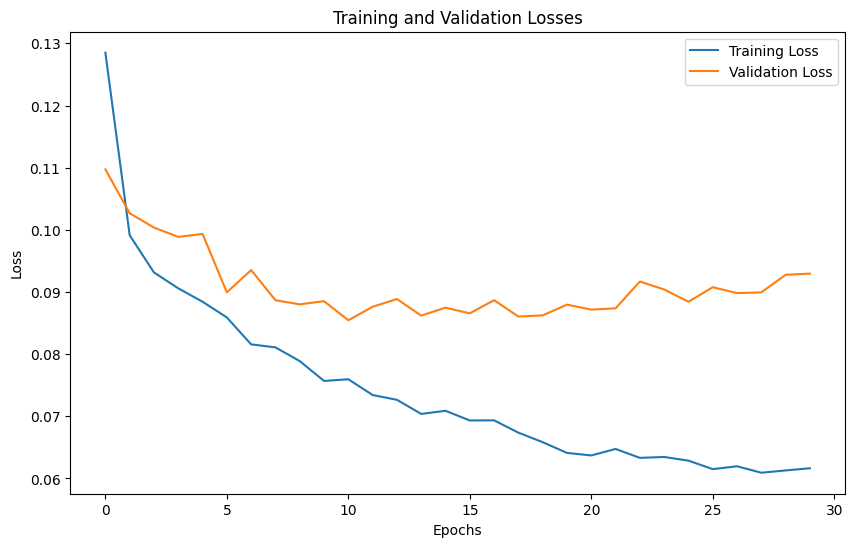


Viewing binary codes for training set:


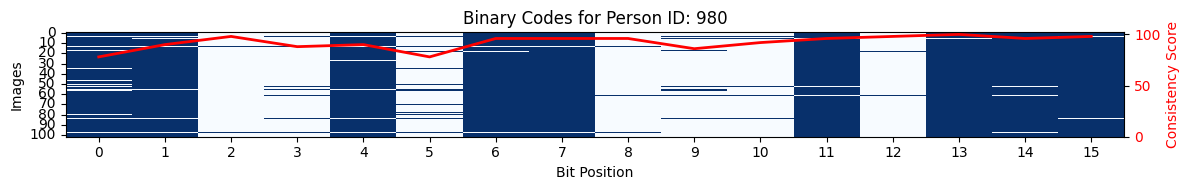

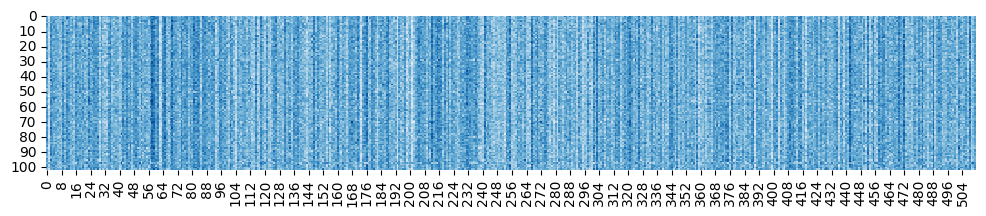

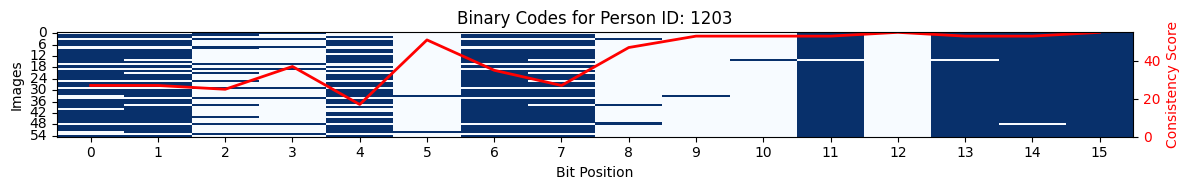

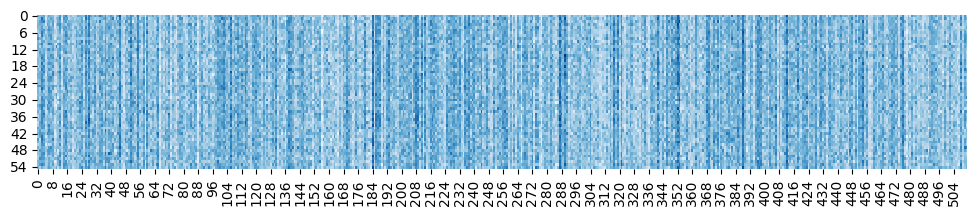

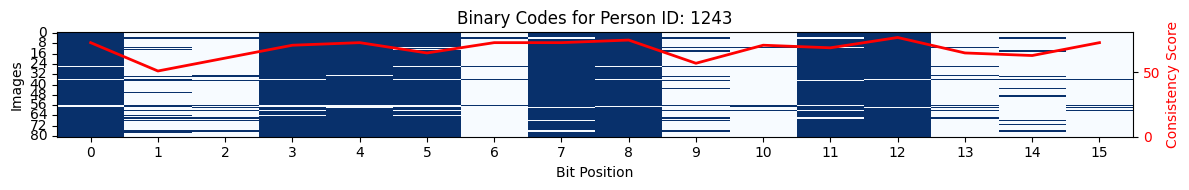

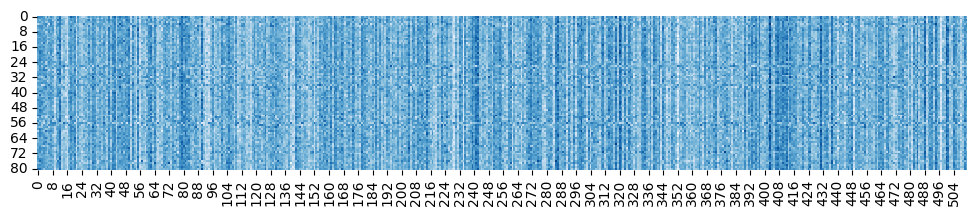


Viewing binary codes for validation set:


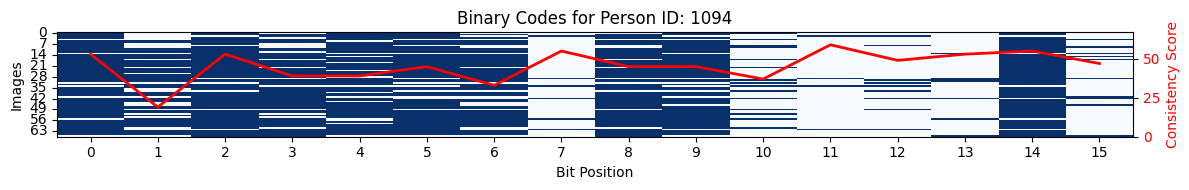

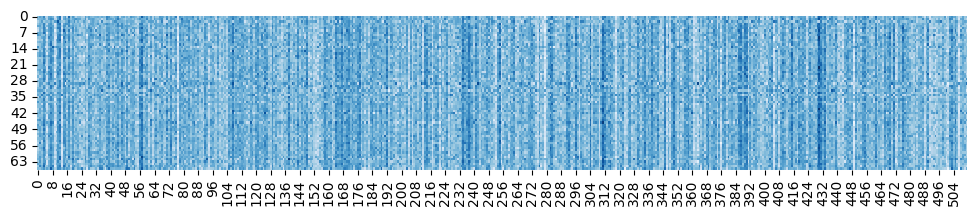

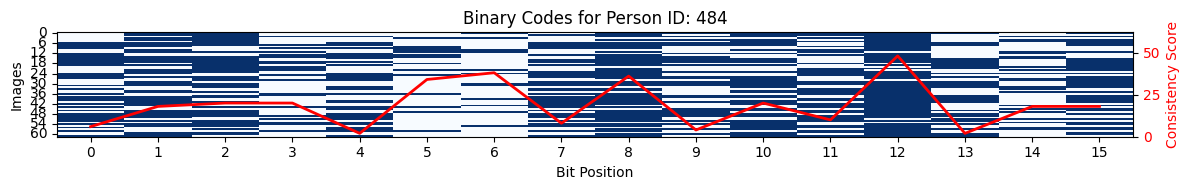

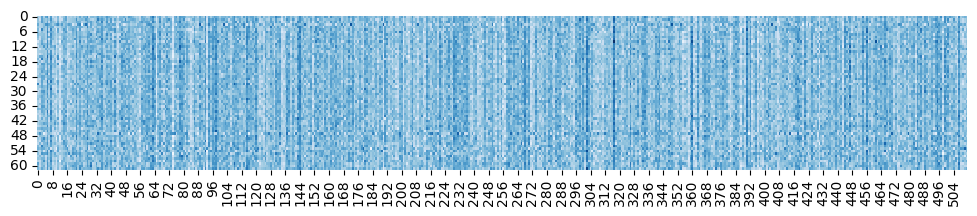

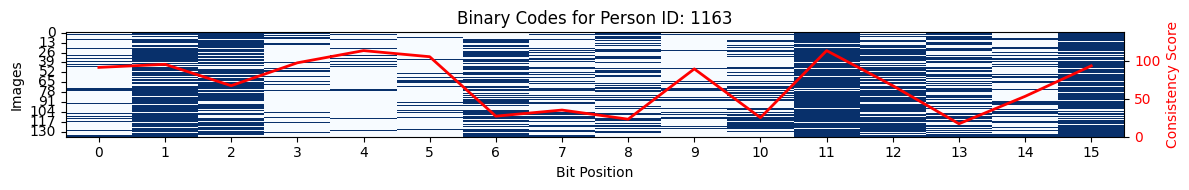

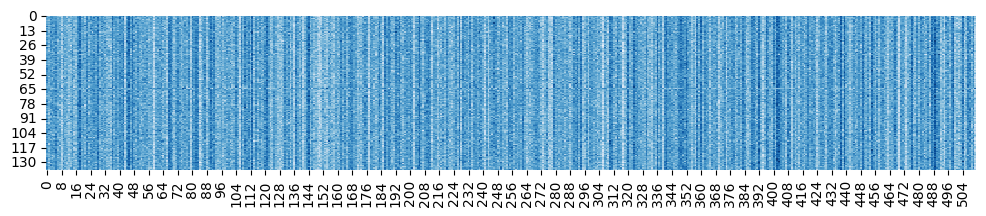


Evaluating on test set:


Calculating Hamming distances: 100%|██████████| 157/157 [00:00<00:00, 263.37it/s]


Average Hamming distance:
  Same person: 5.18 bits
  Different people: 7.96 bits
Best threshold: 7 bits (Accuracy: 69.82%)

Hamming distance distributions:


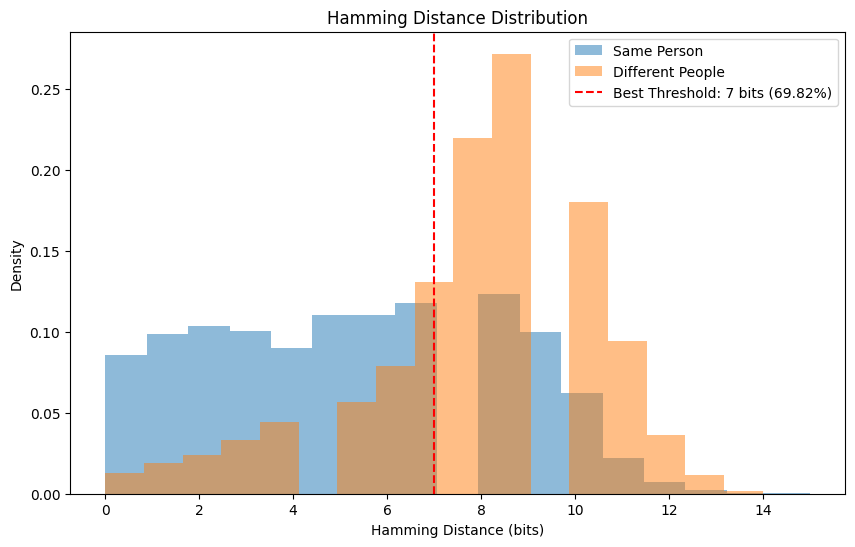


Training completed!
Final training loss: 0.061630
Final validation loss: 0.092950
Best validation loss: 0.085443


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

def plot_person_binary_codes(model, embeddings, pid):
    model.eval()
    
    with torch.no_grad():
        embeddings_tensor = embeddings.to(TORCH_DEVICE)
        binary_outputs = model(embeddings_tensor)
        binary_codes = binarize(binary_outputs).cpu().numpy()
    
    sums = [sum(binary_codes[:, i]) for i in range(binary_codes.shape[1])]
    consistency_scores = np.abs(np.array(sums) - binary_codes.shape[0] / 2) * 2
    
    fig, ax1 = plt.subplots(figsize=(12, 2))
    
    # Plot heatmap on primary axis
    sns.heatmap(binary_codes, cmap="Blues", cbar=False, ax=ax1)
    ax1.set_xlabel("Bit Position")
    ax1.set_ylabel("Images")
    
    # Create secondary y-axis for consistency scores
    ax2 = ax1.twinx()
    ax2.plot(np.arange(0.5, len(consistency_scores) + 0.5), consistency_scores, color='red', linewidth=2, label='Consistency Score')
    ax2.set_ylabel("Consistency Score", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, binary_codes.shape[0])
    ax2.grid(False)
    
    # Set title
    plt.title(f"Binary Codes for Person ID: {pid}")
    plt.tight_layout()
    plt.show()

def plot_persons_binary_codes(model, face_dataset: FaceEmbeddingsDataset, num_people=5, min_images=5):
    model.eval()
    people_with_enough_images = face_dataset.get_person_ids_with_min_images(min_images)
    if len(people_with_enough_images) < num_people:
        num_people = len(people_with_enough_images)
    selected_people = np.random.choice(people_with_enough_images, num_people, replace=False)
    for pid in selected_people:
        embeddings = face_dataset.all_embeddings_of_person_id(pid)
        plot_person_binary_codes(model, embeddings, pid)
        fig,ax = plt.subplots(figsize=(12, 2))
        sns.heatmap(embeddings.cpu().numpy(), cmap="Blues", cbar=False, ax=ax)
        plt.show()

def calculate_hamming_distances(model, face_dataset, sample_size=10000):
    model.eval()
    
    eval_pairs = FacePairsDataset(face_dataset, pairs_per_epoch=sample_size, pos_ratio=0.5)
    eval_loader = DataLoader(eval_pairs, batch_size=64, shuffle=False)
    
    same_person_hamming = []
    diff_person_hamming = []
    
    with torch.no_grad():
        for emb1, emb2, label in tqdm(eval_loader, desc="Calculating Hamming distances"):
            emb1 = emb1.to(TORCH_DEVICE)
            emb2 = emb2.to(TORCH_DEVICE)
            
            bin1 = model(emb1)
            bin2 = model(emb2)
            
            bin1_hard = binarize(bin1)
            bin2_hard = binarize(bin2)
            
            hamming_dist = torch.sum(torch.abs(bin1_hard - bin2_hard), dim=1).cpu().numpy()
            
            for i, l in enumerate(label.cpu().numpy()):
                if l > 0.5:
                    same_person_hamming.append(hamming_dist[i])
                else:
                    diff_person_hamming.append(hamming_dist[i])
    
    same_avg = np.mean(same_person_hamming)
    diff_avg = np.mean(diff_person_hamming)
    
    print(f"Average Hamming distance:")
    print(f"  Same person: {same_avg:.2f} bits")
    print(f"  Different people: {diff_avg:.2f} bits")
    
    all_hamming = np.concatenate([same_person_hamming, diff_person_hamming])
    all_labels = np.concatenate([np.ones(len(same_person_hamming)), np.zeros(len(diff_person_hamming))])
    
    best_threshold = 0
    best_accuracy = 0
    
    for threshold in range(17):
        predictions = (all_hamming < threshold).astype(int)
        accuracy = np.mean(predictions == all_labels)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    print(f"Best threshold: {best_threshold} bits (Accuracy: {best_accuracy*100:.2f}%)")
    
    return {
        'same_avg': same_avg,
        'diff_avg': diff_avg,
        'best_threshold': best_threshold,
        'best_accuracy': best_accuracy,
        'same_person_hamming': same_person_hamming,
        'diff_person_hamming': diff_person_hamming
    }

def plot_hamming_distributions(same_person_hamming, diff_person_hamming, best_threshold, best_accuracy):
    plt.figure(figsize=(10, 6))
    plt.hist(same_person_hamming, bins=17, alpha=0.5, label='Same Person', density=True)
    plt.hist(diff_person_hamming, bins=17, alpha=0.5, label='Different People', density=True)
    plt.axvline(x=best_threshold, color='r', linestyle='--', 
                label=f'Best Threshold: {best_threshold} bits ({best_accuracy*100:.2f}%)')
    plt.xlabel('Hamming Distance (bits)')
    plt.ylabel('Density')
    plt.title('Hamming Distance Distribution')
    plt.legend()
    plt.show()

print("\nViewing loss curves:")
plot_loss_curves(history['train_losses'], history['val_losses'])

print("\nViewing binary codes for training set:")
plot_persons_binary_codes(best_model, train_dataset, num_people=3, min_images=50)

print("\nViewing binary codes for validation set:")
plot_persons_binary_codes(best_model, val_dataset, num_people=3, min_images=50)

print("\nEvaluating on test set:")
best_metrics = calculate_hamming_distances(best_model, test_dataset)

print("\nHamming distance distributions:")
plot_hamming_distributions(
    best_metrics['same_person_hamming'], 
    best_metrics['diff_person_hamming'], 
    best_metrics['best_threshold'], 
    best_metrics['best_accuracy']
)

print("\nTraining completed!")
print(f"Final training loss: {history['final_train_loss']:.6f}")
print(f"Final validation loss: {history['final_val_loss']:.6f}")
print(f"Best validation loss: {history['best_val_loss']:.6f}")

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

/tmp/ipykernel_644/3450467302.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  plot_person_binary_codes(model, torch.FloatTensor(embeddings), video_file)


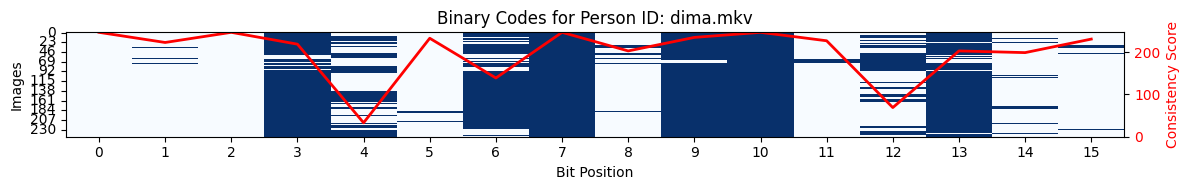

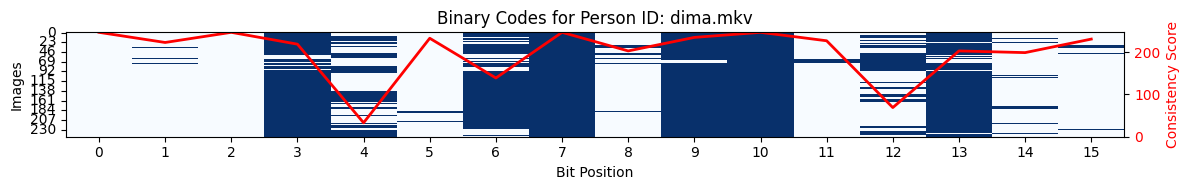

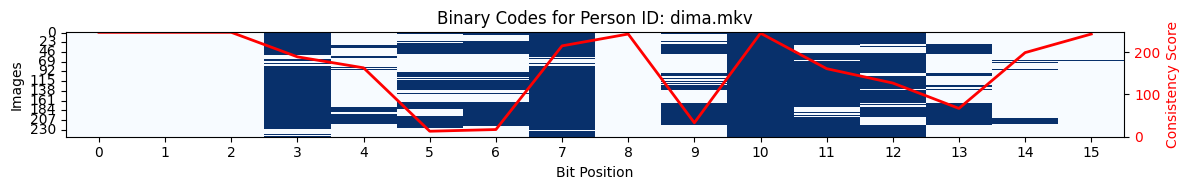

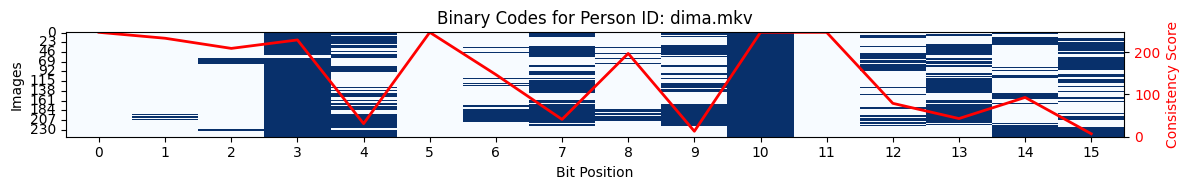

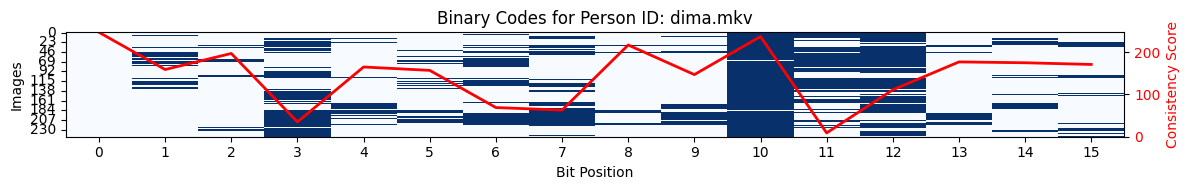

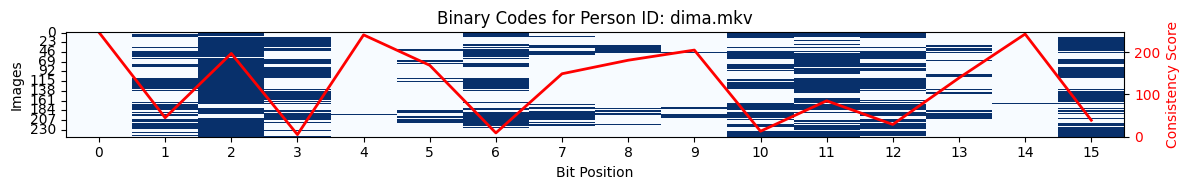

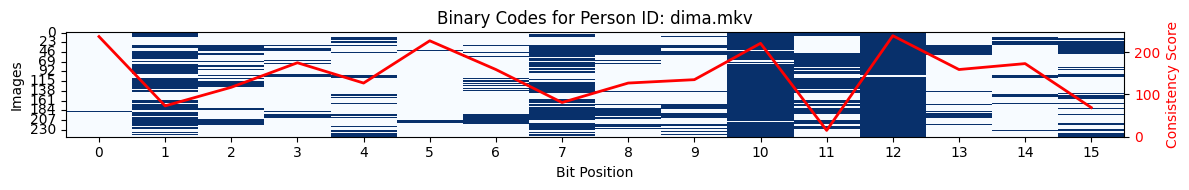

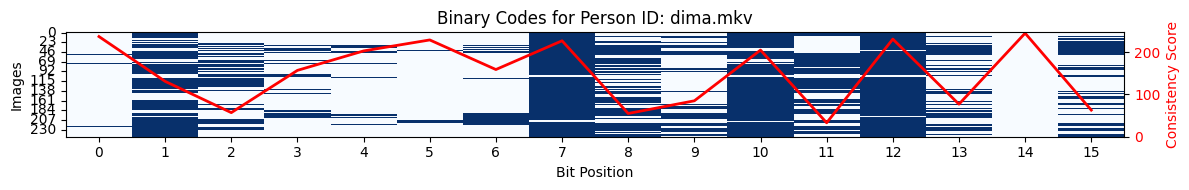

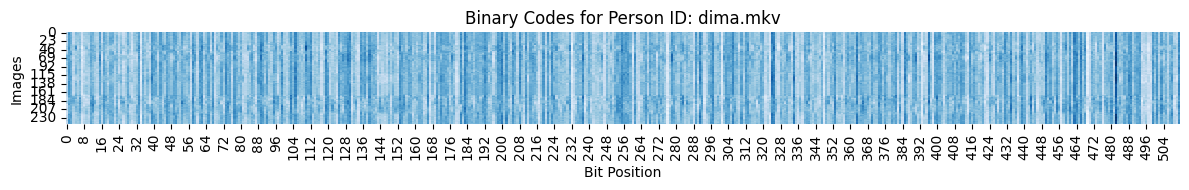

Processing ./videos/eldar.mp4...
Extracted 161/161 frames from ./videos/eldar.mp4


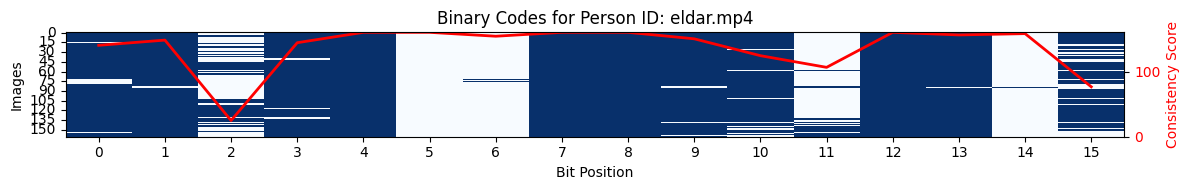

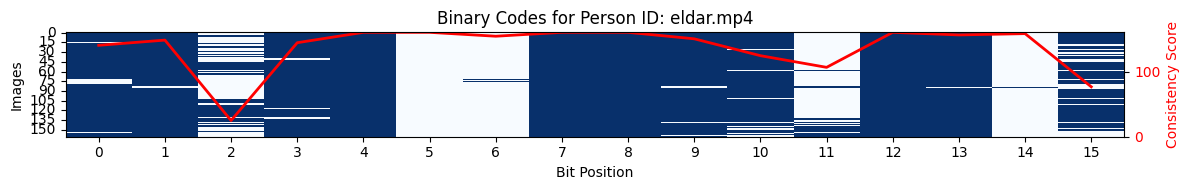

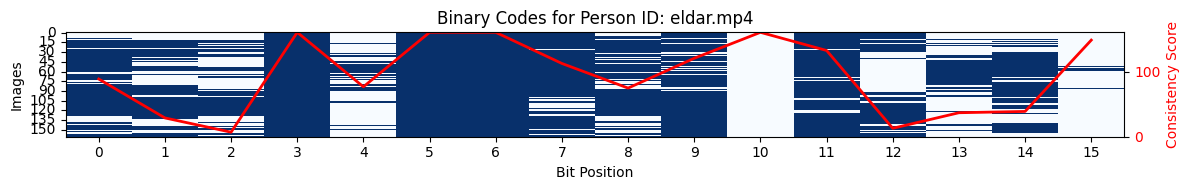

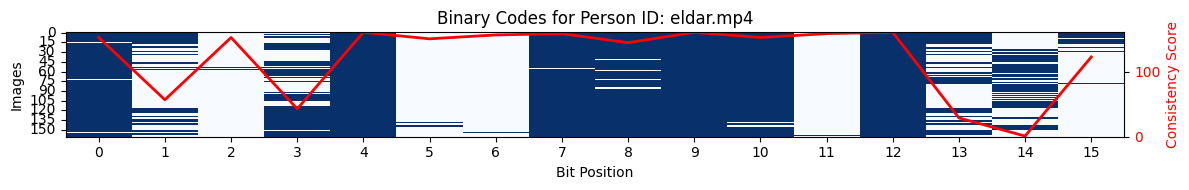

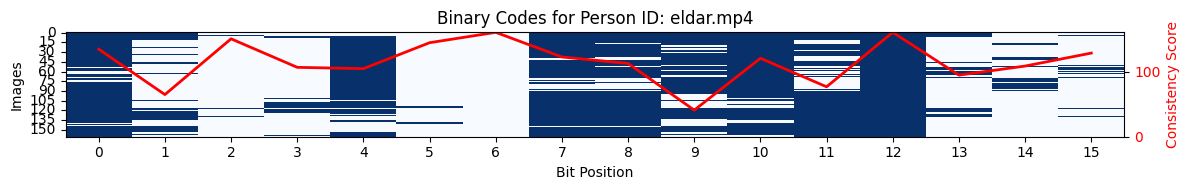

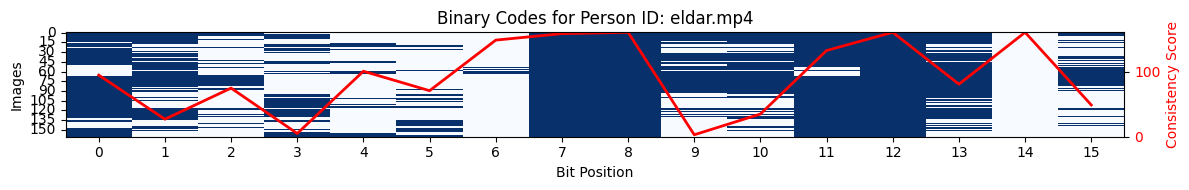

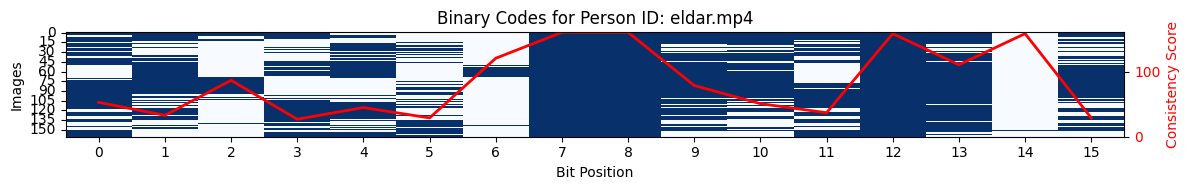

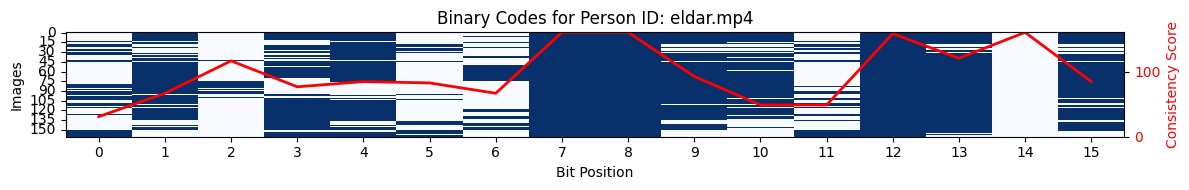

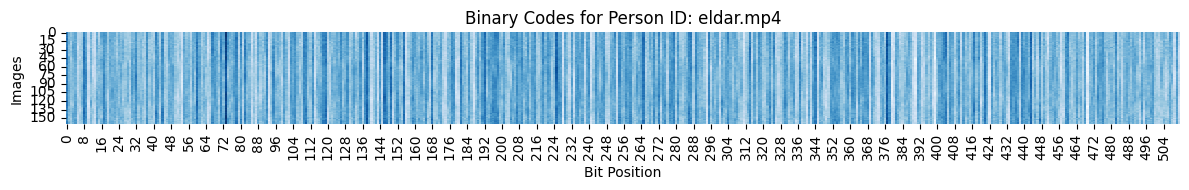

Processing ./videos/eldar2.mp4...
Extracted 182/182 frames from ./videos/eldar2.mp4


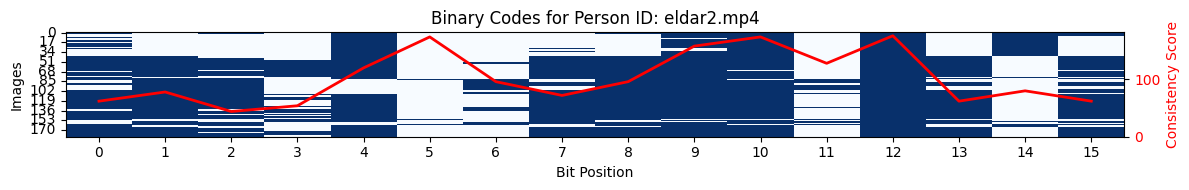

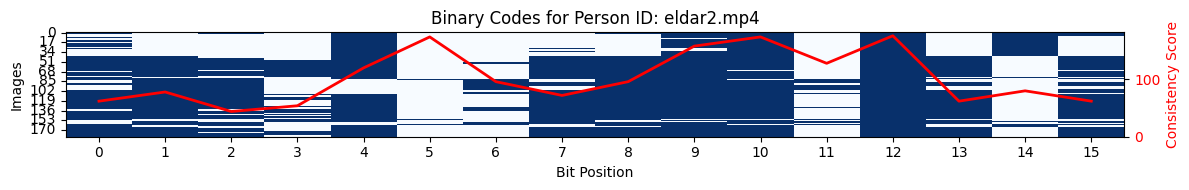

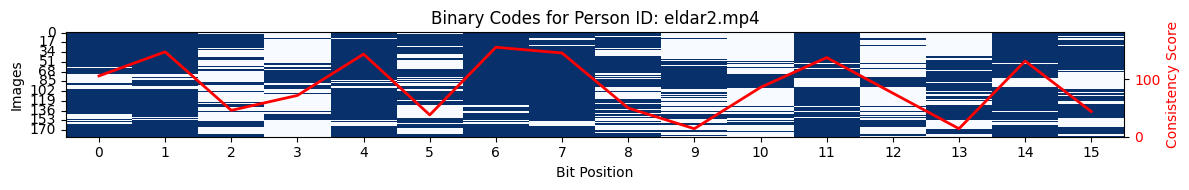

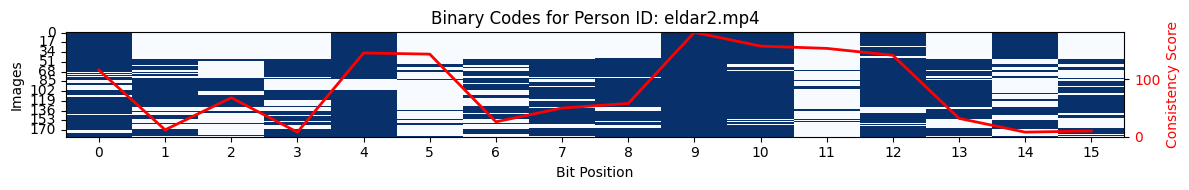

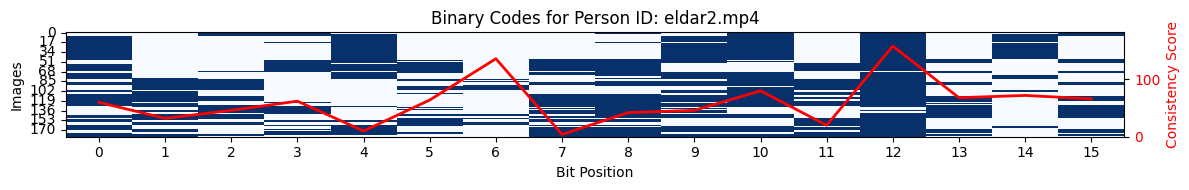

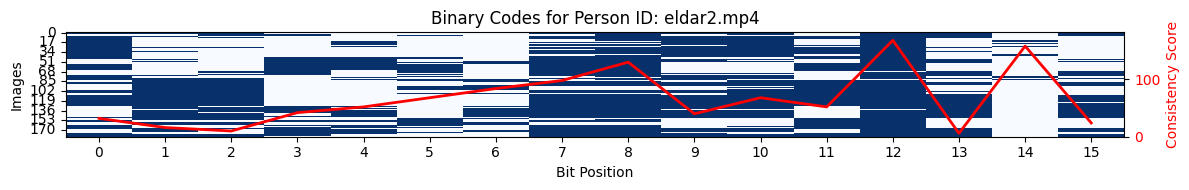

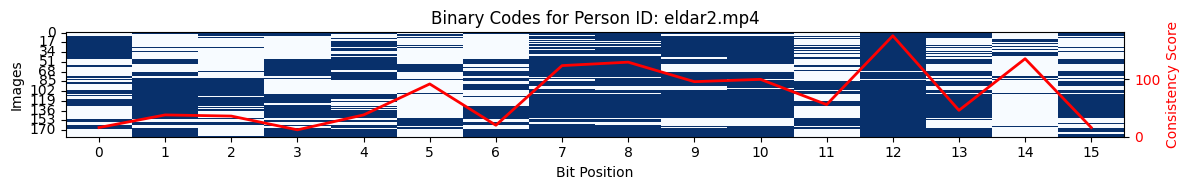

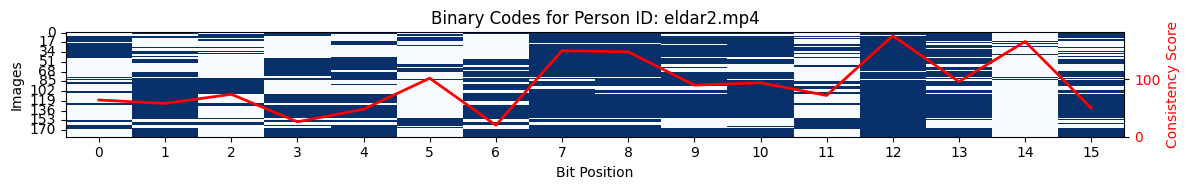

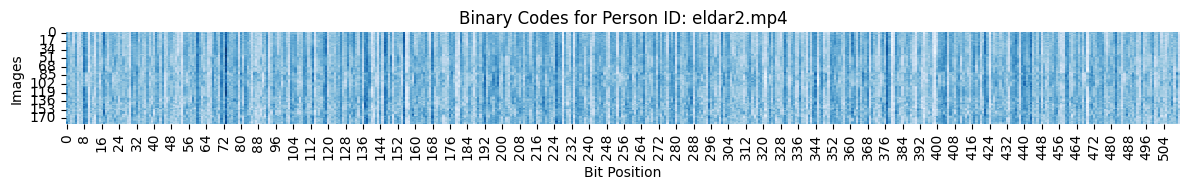

Processing ./videos/eldar3.mp4...
Extracted 17/70 frames from ./videos/eldar3.mp4


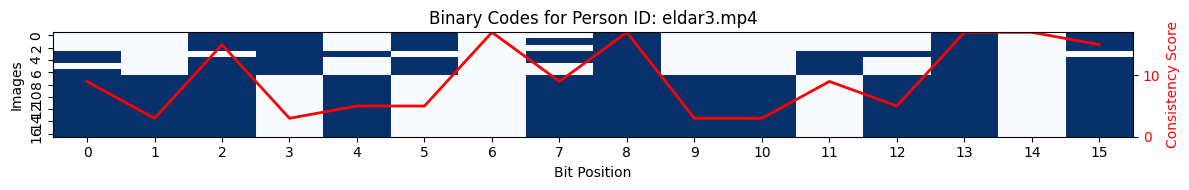

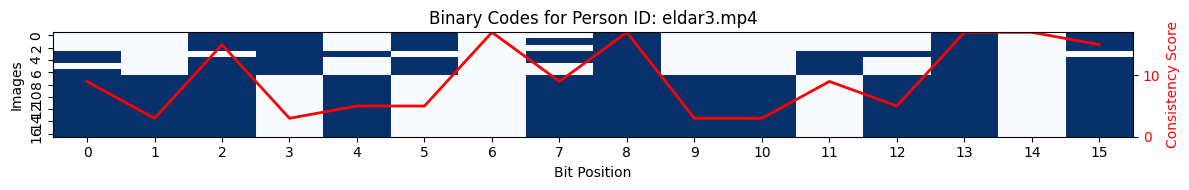

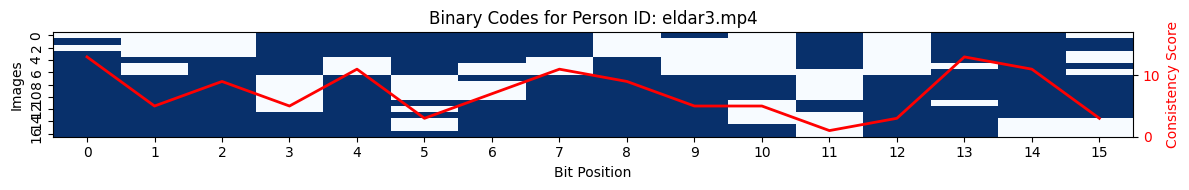

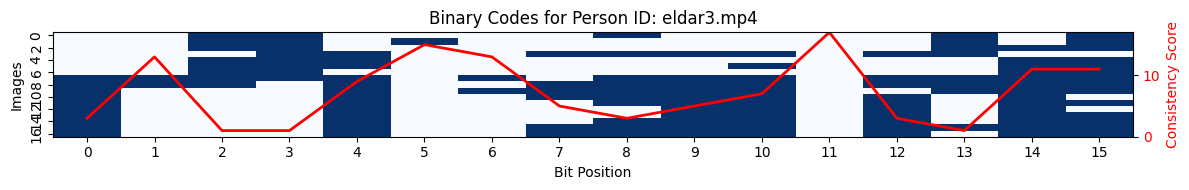

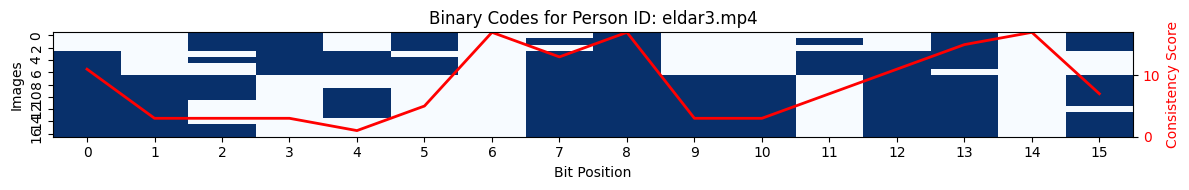

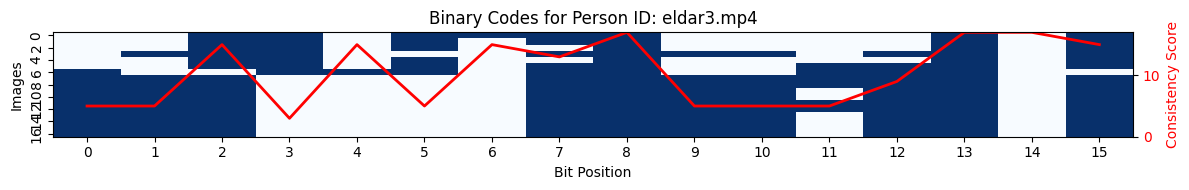

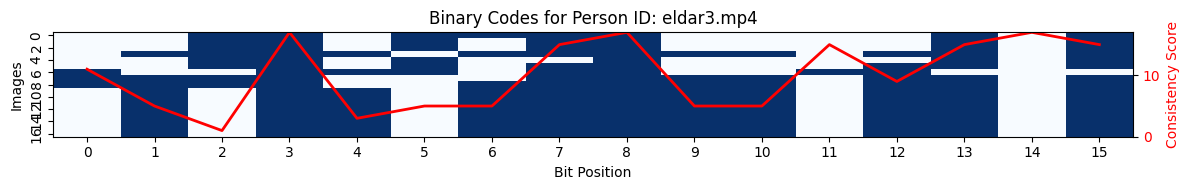

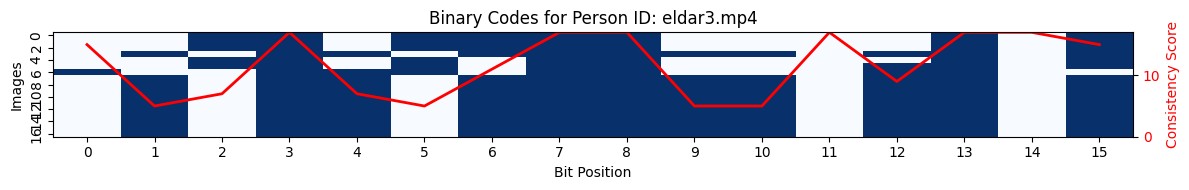

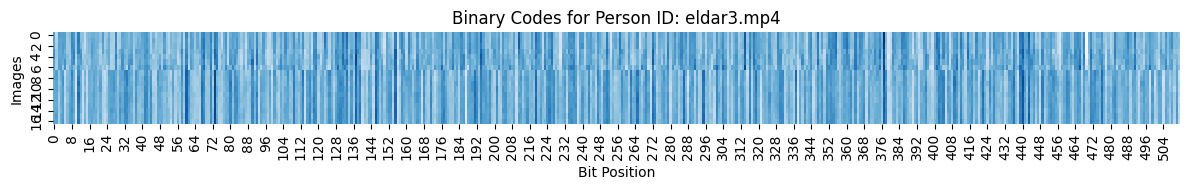

Processing ./videos/lexa.mp4...
Extracted 192/226 frames from ./videos/lexa.mp4


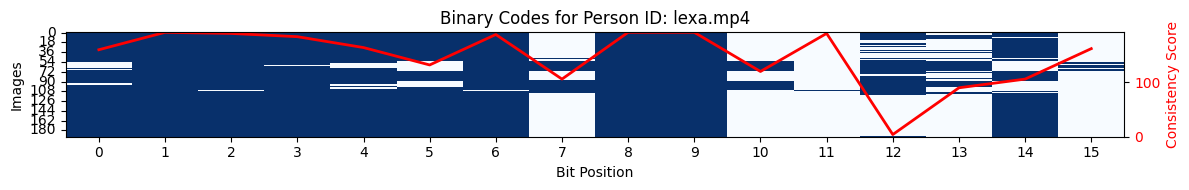

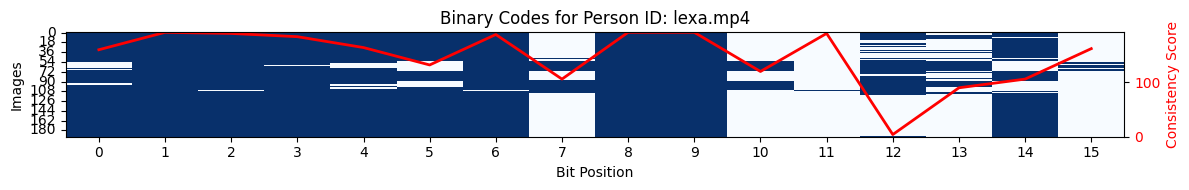

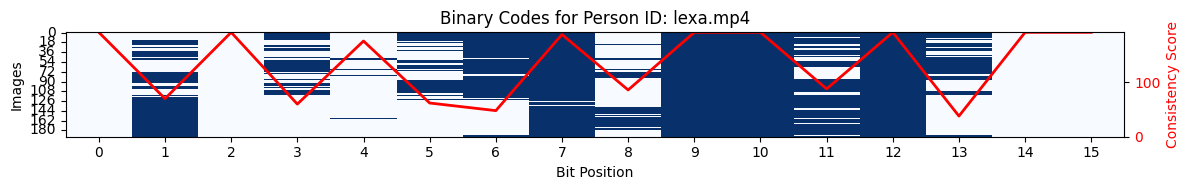

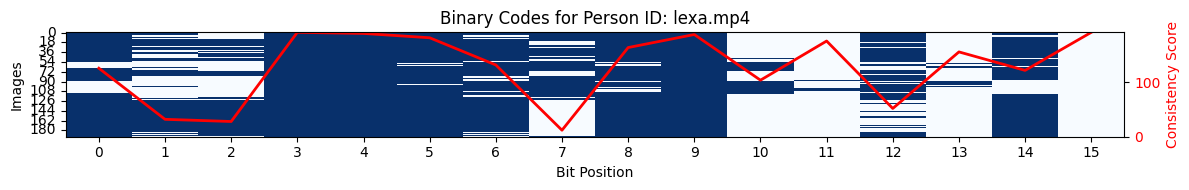

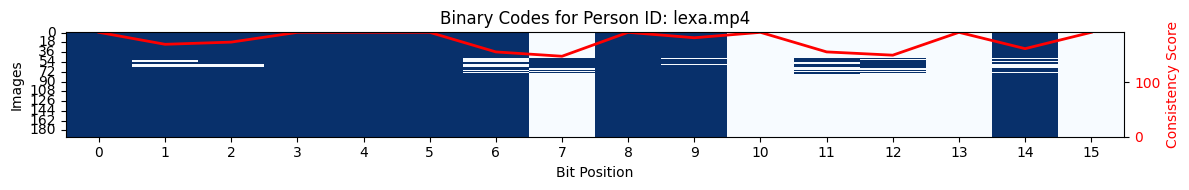

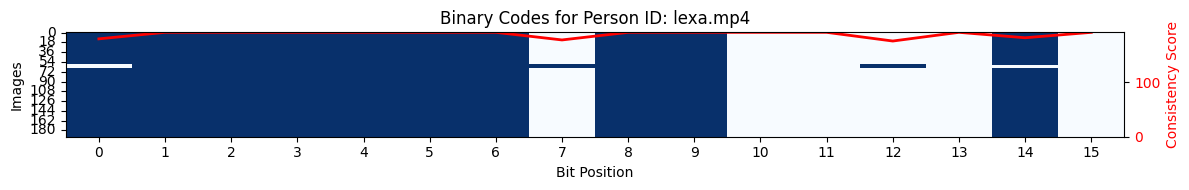

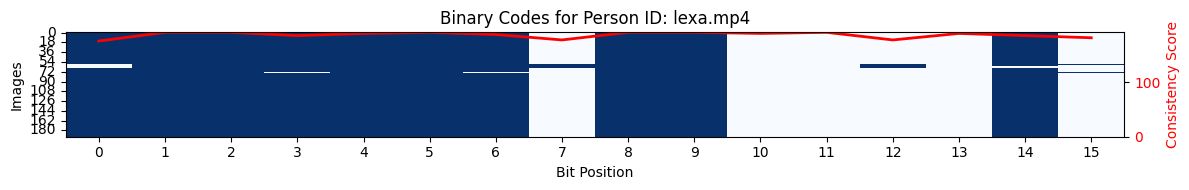

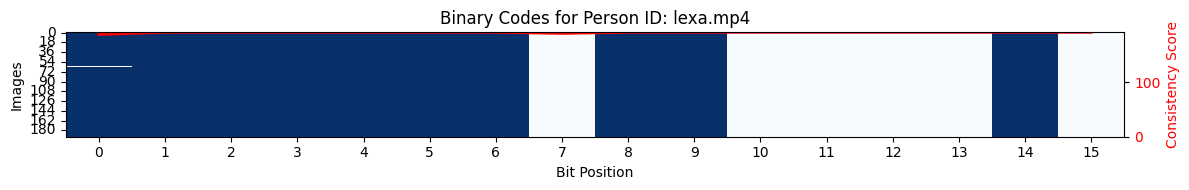

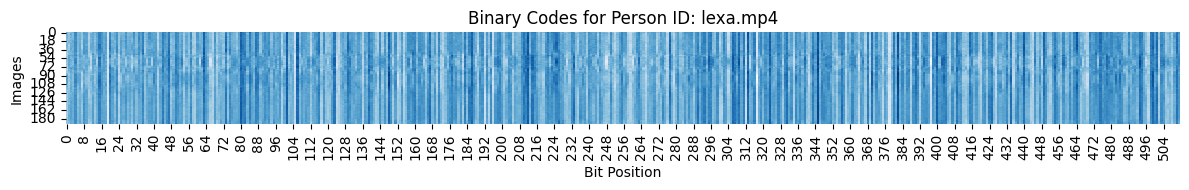

Processing ./videos/lexa2.mp4...
Extracted 341/341 frames from ./videos/lexa2.mp4


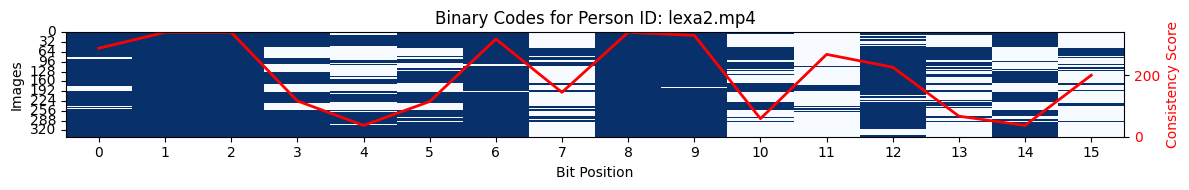

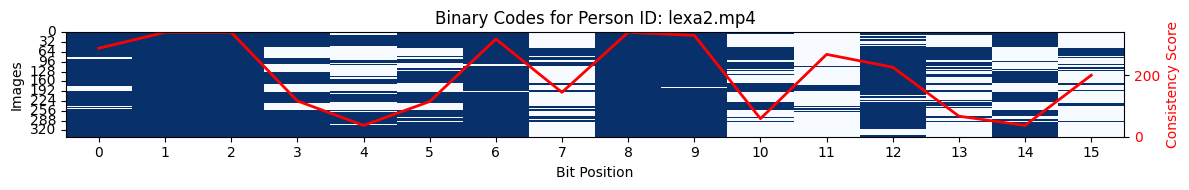

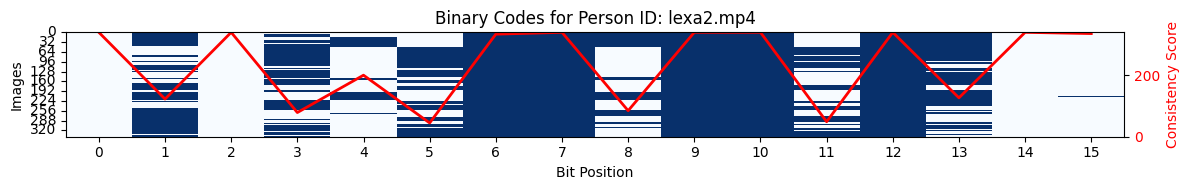

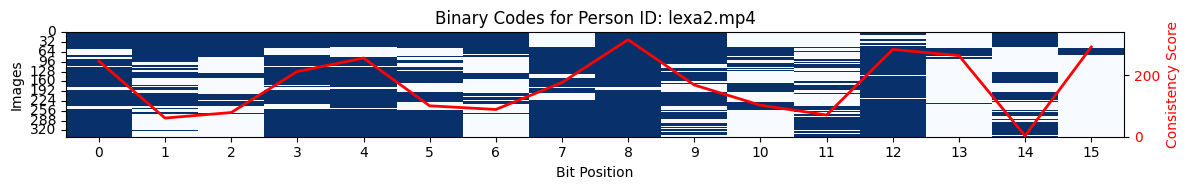

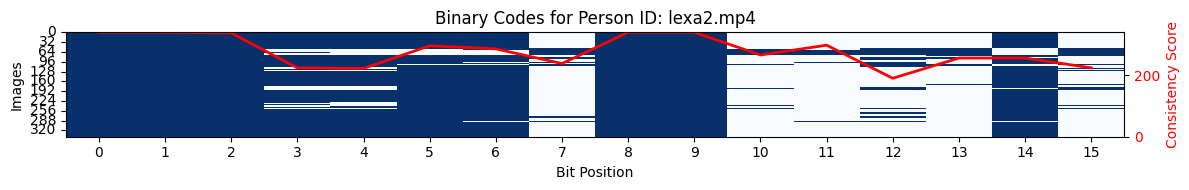

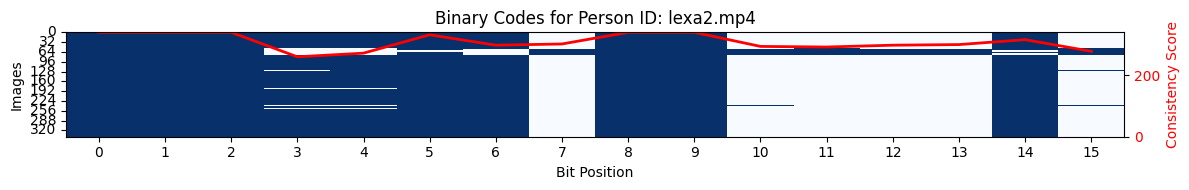

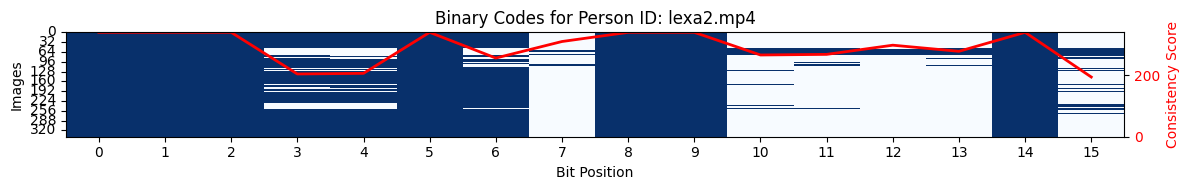

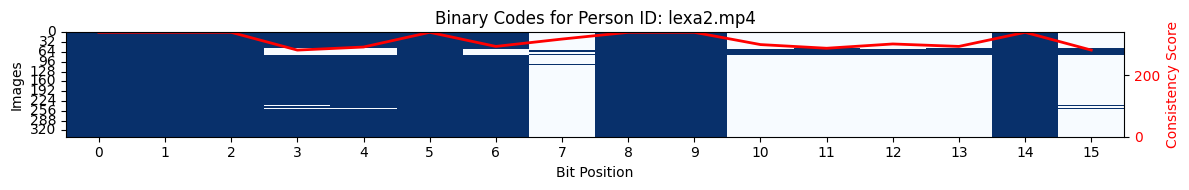

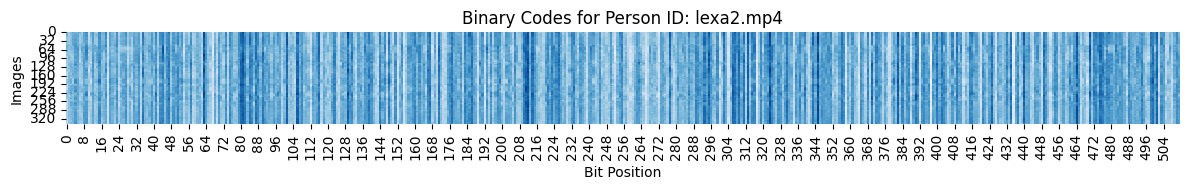

In [5]:
import cv2
import insightface
from insightface.utils import face_align
from insightface.model_zoo import RetinaFace, ArcFaceONNX

app = insightface.app.FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0)
detection_model: RetinaFace = app.models['detection']
recognition_model: ArcFaceONNX = app.models['recognition']
def try_detect_face(img):
    bboxes, kpss = detection_model.detect(img,max_num=1)
    kps = None
    try:
        if kpss is not None:
            kps = kpss[0]
    except Exception as e:
        return None
    return face_align.norm_crop(img, landmark=kps, image_size=112)

def video_to_embeddings(video_path: str):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0
    embeddings = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        maybe_face = try_detect_face(frame)
        if maybe_face is not None:
            extracted_count += 1
            embedding = recognition_model.get_feat(maybe_face)[0]
            embedding = np.array(embedding)
            embeddings.append(embedding)
        frame_count += 1
    cap.release()
    print(f"Extracted {extracted_count}/{frame_count} frames from {video_path}")
    return embeddings

def plot_person_embeddings(embeddings, pid):
    fig, ax = plt.subplots(figsize=(12, 2))
    sns.heatmap(embeddings, cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel("Bit Position")
    ax.set_ylabel("Images")
    plt.title(f"Binary Codes for Person ID: {pid}")
    plt.tight_layout()
    plt.show()

def eval_on_videos(videos_dir="./videos", models: list[BinaryEncoderNetwork] = [best_model]):
    video_files_unsorted = [f for f in os.listdir(videos_dir) if f.endswith(('.mp4', '.avi', '.mkv'))]
    video_files = sorted(video_files_unsorted)
    all_embeddings = {}
    
    for video_file in video_files:
        video_path = os.path.join(videos_dir, video_file)
        print(f"Processing {video_path}...")
        embeddings = video_to_embeddings(video_path)
        all_embeddings[video_file] = embeddings
        for model in models:
            plot_person_binary_codes(model, torch.FloatTensor(embeddings), video_file)
        plot_person_embeddings(torch.FloatTensor(embeddings), video_file)
    
    return all_embeddings
videos_embeddings = eval_on_videos(models=[best_model,
                                            load_binary_encoder("binary_encoder_checkpoints", "binary_encoder_best.pt")[0],
                                            load_binary_encoder("binary_encoder_checkpoints", "binary_encoder_epoch_5.pt")[0],
                                            load_binary_encoder("binary_encoder_checkpoints", "binary_encoder_epoch_10.pt")[0],
                                            load_binary_encoder("binary_encoder_checkpoints", "binary_encoder_epoch_15.pt")[0],
                                            load_binary_encoder("binary_encoder_checkpoints", "binary_encoder_epoch_20.pt")[0],
                                            load_binary_encoder("binary_encoder_checkpoints", "binary_encoder_epoch_25.pt")[0],
                                            load_binary_encoder("binary_encoder_checkpoints", "binary_encoder_epoch_30.pt")[0]
                                           ])